In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import h5py
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models


mat_folder_path = '/content/drive/your_path/your_data'


mat_files = [f for f in os.listdir(mat_folder_path) if f.endswith('.mat')]


X_train_list = []
Y_train_list = []


for mat_file in mat_files:
    mat_path = os.path.join(mat_folder_path, mat_file)

    with h5py.File(mat_path, 'r') as f:
        print(f"İşleniyor: {mat_file}")
        print(list(f.keys()))  

        cjdata = f['cjdata']  # Ana veri yapısı
        image = cjdata['image'][:]  # MRI görüntüsü
        label = cjdata['label'][()]  # Tümör tipi (Skaler değer)
        tumor_mask = cjdata['tumorMask'][:]  # Tümör maskesi

        print(f"Görüntü Boyutu: {image.shape}")
        print(f"Tümör Türü: {label}")

       
        image = image.astype(np.float32) / 255.0  

        
        tumor_mask = tumor_mask.astype(np.float32)

        
        image_resized = cv2.resize(image, (256, 256))
        mask_resized = cv2.resize(tumor_mask, (256, 256))

        print(f"Yeni Görüntü Boyutu: {image_resized.shape}")
        print(f"Yeni Maske Boyutu: {mask_resized.shape}")

        
        X_train_list.append(np.expand_dims(image_resized, axis=-1))  # (256, 256, 1)
        Y_train_list.append(np.expand_dims(mask_resized, axis=-1))   # (256, 256, 1)


X_train = np.array(X_train_list)  
Y_train = np.array(Y_train_list)  

import tensorflow as tf
from tensorflow.keras import layers, models

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice

def improved_unet(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])
    return model


unet = improved_unet()
unet.summary()



print(f"X_train Boyutu: {X_train.shape}")
print(f"Y_train Boyutu: {Y_train.shape}")


unet.fit(X_train, Y_train, epochs=50, batch_size=16)


İşleniyor: 1.mat
['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
Yeni Görüntü Boyutu: (256, 256)
Yeni Maske Boyutu: (256, 256)
İşleniyor: 5.mat
['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
Yeni Görüntü Boyutu: (256, 256)
Yeni Maske Boyutu: (256, 256)
İşleniyor: 2.mat
['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
Yeni Görüntü Boyutu: (256, 256)
Yeni Maske Boyutu: (256, 256)
İşleniyor: 3.mat
['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
Yeni Görüntü Boyutu: (256, 256)
Yeni Maske Boyutu: (256, 256)
İşleniyor: 6.mat
['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
Yeni Görüntü Boyutu: (256, 256)
Yeni Maske Boyutu: (256, 256)
İşleniyor: 4.mat
['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
Yeni Görüntü Boyutu: (256, 256)
Yeni Maske Boyutu: (256, 256)
İşleniyor: 13.mat
['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
Yeni Görüntü Boyutu: (256, 256)
Yeni Maske Boyutu: (256, 256)
İşleniyor: 19.mat
['cjdata']
Görüntü Boyutu: (5

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

X_train Boyutu: (766, 256, 256, 1)
Y_train Boyutu: (766, 256, 256, 1)
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9081 - loss: 0.6566
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 718ms/step - accuracy: 0.9683 - loss: 0.4652
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 713ms/step - accuracy: 0.9703 - loss: 0.4480
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 709ms/step - accuracy: 0.9669 - loss: 0.4526
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 714ms/step - accuracy: 0.9664 - loss: 0.4182
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 711ms/step - accuracy: 0.9693 - loss: 0.3498
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 710ms/step - accuracy: 0.9806 - loss: 0.3049
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 708ms/step - accuracy: 0.9879 - loss: 0.2177
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 709ms/step - accuracy: 0.9883 - loss: 0.2033
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 714ms/step - accuracy: 0.9905 - loss: 0.1623
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 711ms/step - accur

['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


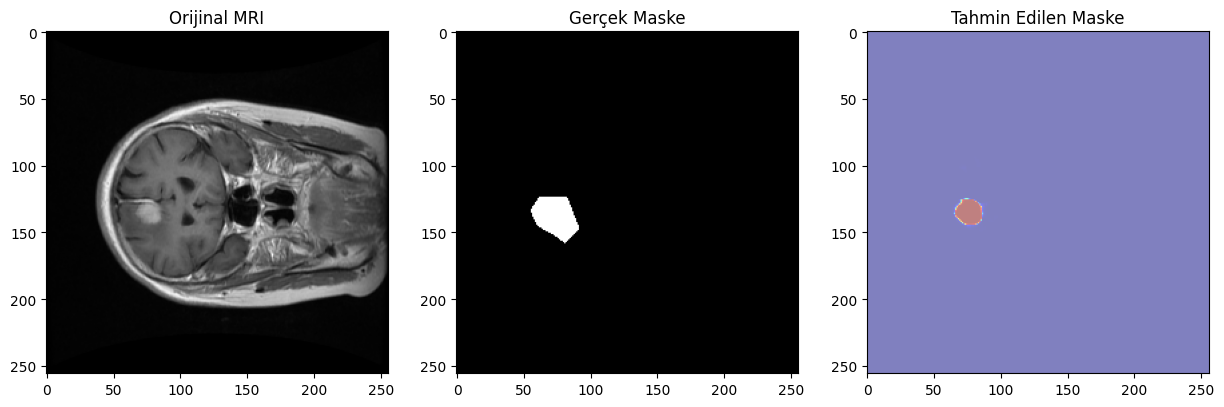

['cjdata']
Görüntü Boyutu: (512, 512)
Tümör Türü: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


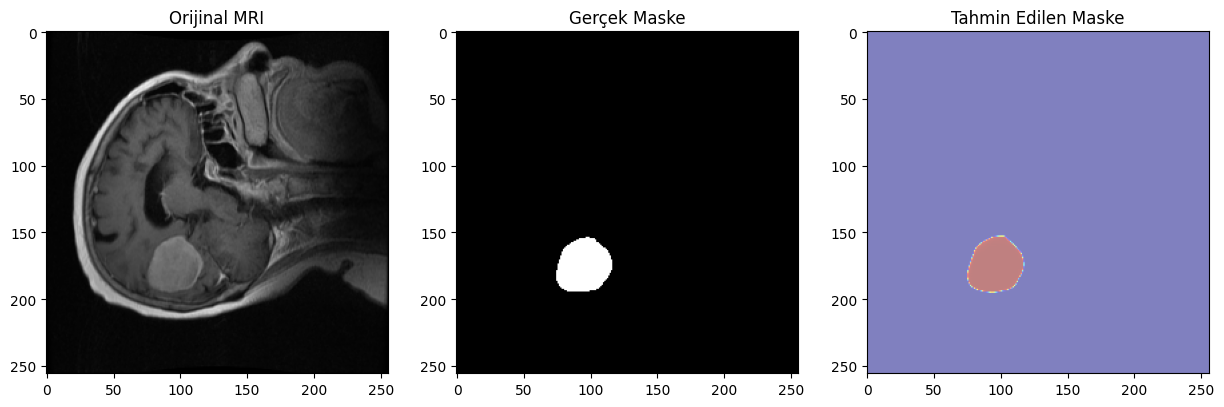

In [44]:
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt

# .mat dosyasını yüklemek için fonksiyon
def test_model_on_mat(mat_path):
    
    with h5py.File(mat_path, 'r') as f:
        print(list(f.keys()))  

        cjdata = f['cjdata']  # Ana veri yapısı
        image = np.array(cjdata['image'])  # MRI görüntüsü
        label = np.array(cjdata['label'])[()]  # Tümör tipi (Skaler değer)
        tumor_mask = np.array(cjdata['tumorMask'])  # Tümör maskesi

    print(f"Görüntü Boyutu: {image.shape}")
    print(f"Tümör Türü: {label}")

    
    image_resized = cv2.resize(image, (256, 256)).astype(np.float32)
    tumor_mask_resized = cv2.resize(tumor_mask, (256, 256))  

    image_resized = np.expand_dims(image_resized, axis=-1) / 255.0
    image_input = np.expand_dims(image_resized, axis=0)  

 
    pred_mask = unet.predict(image_input)[0, :, :, 0]

    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_resized.squeeze(), cmap='gray')
    plt.title("Orijinal MRI")

    plt.subplot(1, 3, 2)
    plt.imshow(tumor_mask_resized, cmap='gray')
    plt.title("Gerçek Maske")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='jet', alpha=0.5)
    plt.title("Tahmin Edilen Maske")

    plt.show()


mat_file_path = "/content/drive/My Drive/3064.mat"  
test_model_on_mat(mat_file_path)
mat_file_path2 = "/content/drive/My Drive/3030.mat"
test_model_on_mat(mat_file_path2)
